In [1]:
import pandas as pd
import cv2
import os
import ast

# --- CONFIGURATION ---
CSV_FILE = '/content/annotations.csv'
IMAGES_DIR = '/content/images/'
LABELS_DIR = '/content/labels/'  # YOLO will look for this folder automatically

# Create labels directory
if not os.path.exists(LABELS_DIR):
    os.makedirs(LABELS_DIR)

print("Loading dataset...")
df = pd.read_csv(CSV_FILE)

# Helper to parse the list-of-tuples string: "[(x,y), (x,y)...]"
def parse_geometry(geo_data):
    try:
        coords_list = ast.literal_eval(geo_data)
        xs = [pt[0] for pt in coords_list]
        ys = [pt[1] for pt in coords_list]
        return min(xs), min(ys), max(xs), max(ys)
    except Exception as e:
        return None

print(f"Found {len(df)} annotations. Processing...")

count = 0
for index, row in df.iterrows():
    filename = row['image_id']
    geometry = row['geometry']

    # 1. Get Image Size
    img_path = os.path.join(IMAGES_DIR, filename)
    if not os.path.exists(img_path): continue # Skip missing images

    image = cv2.imread(img_path)
    if image is None: continue
    h_img, w_img, _ = image.shape

    # 2. Get Box Coordinates
    coords = parse_geometry(geometry)
    if coords is None: continue
    xmin, ymin, xmax, ymax = coords

    # 3. Normalize for YOLO (0-1 scale)
    x_center = ((xmin + xmax) / 2) / w_img
    y_center = ((ymin + ymax) / 2) / h_img
    w_norm = (xmax - xmin) / w_img
    h_norm = (ymax - ymin) / h_img

    # 4. Save (Class ID 0 = Airplane)
    txt_filename = os.path.splitext(filename)[0] + ".txt"
    with open(os.path.join(LABELS_DIR, txt_filename), 'a') as f:
        f.write(f"0 {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")

    count += 1

print(f"Success! Created {count} label files in {LABELS_DIR}")

Loading dataset...
Found 3425 annotations. Processing...
Success! Created 3425 label files in /content/labels/


In [2]:
# 1. Clone the YOLOv5 code repository
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt  # Install dependencies

# 2. Create the configuration file (dataset.yaml)
# This file tells the AI: "Images are here, and Class 0 means 'Airplane'"
import yaml

config = {
    'path': '/content',          # Root dir
    'train': 'images',           # Train images (YOLO automatically looks for ../labels)
    'val': 'images',             # Validation images (just using same folder for simplicity)
    'nc': 1,                     # Number of classes
    'names': ['Airplane']        # Class names
}

with open('dataset.yaml', 'w') as f:
    yaml.dump(config, f)

print("Setup complete. Ready to train.")

Cloning into 'yolov5'...
remote: Enumerating objects: 17739, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 17739 (delta 57), reused 31 (delta 31), pack-reused 17643 (from 4)
Receiving objects: 100% (17739/17739), 17.16 MiB | 24.13 MiB/s, done.
Resolving deltas: 100% (12047/12047), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.7 MB/s eta 0:00:00
Setup complete. Ready to train.


In [4]:
# Train YOLOv5s (Small model) for 50 epochs
!python train.py --img 640 --batch 16 --epochs 50 --data dataset.yaml --weights yolov5s.pt

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-11-18 19:35:33.512070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763494533.532076    8012 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763494533.538278    8012 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763494533.553518    8012 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763494533.553547    8012 computation_placer.cc:177] computation placer already registere

Showing results from: runs/train/exp2


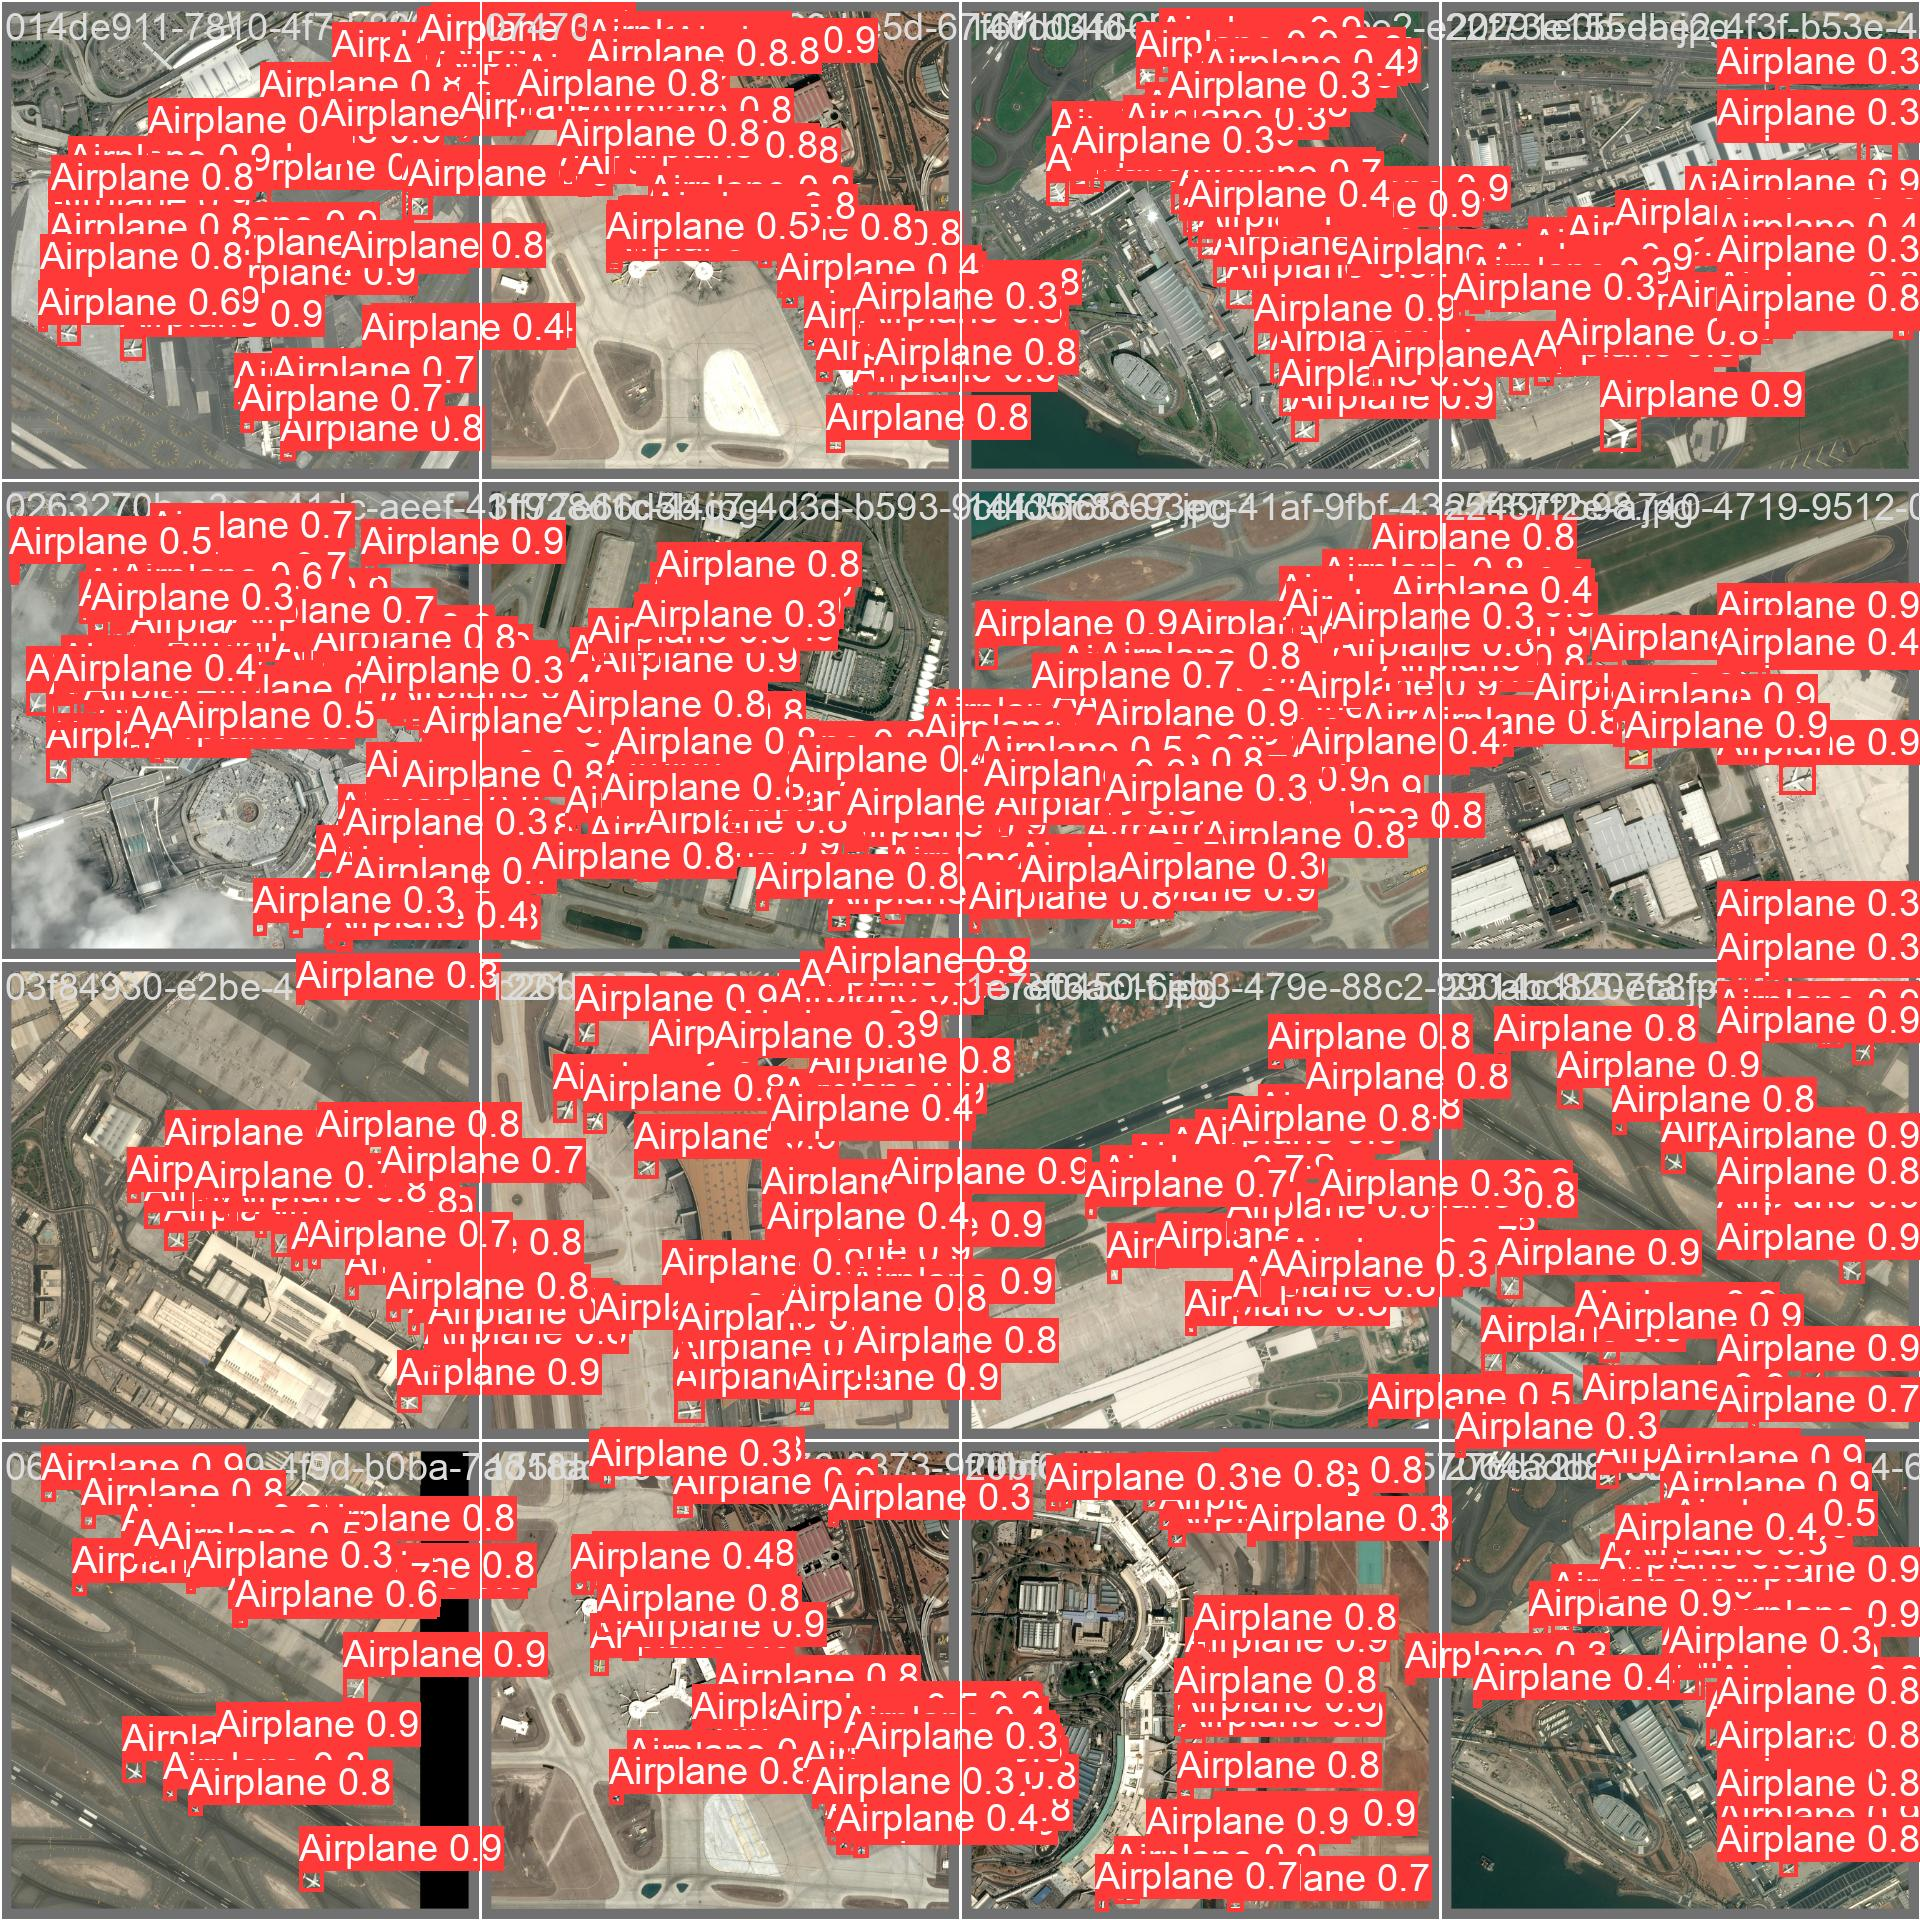

In [5]:
from IPython.display import Image, display
import os

# Find the latest results folder
exp_dir = max([os.path.join('runs/train', d) for d in os.listdir('runs/train')], key=os.path.getmtime)

# Show the detection image
print(f"Showing results from: {exp_dir}")
display(Image(filename=os.path.join(exp_dir, 'val_batch0_pred.jpg')))